In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, Phrases
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

import networkx as nx
import itertools
from collections import Counter

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

df = pd.read_csv('tumblr_data.csv', engine='python')
print(df.head())

  ID                                           Post URL  \
0  1  https://neil-gaiman.tumblr.com/post/7413232854...   
1  2  https://neil-gaiman.tumblr.com/post/7549324046...   
2  3  https://neil-gaiman.tumblr.com/post/7549161067...   
3  4  https://neil-gaiman.tumblr.com/post/7548952832...   
4  5  https://neil-gaiman.tumblr.com/post/7548952378...   

                      Date                                            Content  
0  2024-02-03 17:22:57 GMT  Before you ask a Good Omens question, look her...  
1  2024-07-02 22:34:04 GMT  Hello Neil,\nyou work with Amazon and BBC Stud...  
2  2024-07-02 18:15:02 GMT  *releases pack of dads into home depot* go……be...  
3  2024-07-02 12:44:03 GMT  i wish i was famous in the 70s so i coulda gon...  
4  2024-07-02 12:43:19 GMT  Here is the goggle doc on what to do! Even if ...  


[nltk_data] Downloading package punkt to /Users/amira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/amira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/amira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def is_too_short(text, min_words=5):
    return len(text.split()) < min_words

df['Content'] = df['Content'].fillna('').astype(str)
df = df[~df['Content'].apply(is_too_short)]
df.reset_index(drop=True, inplace=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
custom_exclude = {"hello", "http", "tumblr"}

def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    processed = []
    for token in tokens:
        if token.isalpha() and token not in stop_words and token not in custom_exclude:
            processed.append(lemmatizer.lemmatize(token))
    return processed  # Removed POS tagging

# Apply preprocessing
print("\nPreprocessing data...")
df['Processed'] = df['Content'].apply(preprocess)

# Add bigrams
print("Detecting bigrams...")
bigram_phraser = Phrases(df['Processed'], min_count=5, threshold=20)
df['Processed'] = df['Processed'].apply(lambda x: bigram_phraser[x])


Preprocessing data...
Detecting bigrams...


In [3]:
# TF-IDF analysis
print("\nCalculating TF-IDF...")
joined_docs = df['Processed'].apply(lambda x: " ".join(x))
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(joined_docs)

avg_tfidf = tfidf_matrix.mean(axis=0).A1
words = tfidf.get_feature_names_out()
word_scores = sorted(zip(words, avg_tfidf), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 TF-IDF words:")
for word, score in word_scores:
    print(f"{word}: {score:.4f}")


Calculating TF-IDF...

Top 5 TF-IDF words:
book: 0.0327
one: 0.0258
like: 0.0255
know: 0.0254
good_omen: 0.0246


In [4]:
print("\nPreparing LDA...")
processed_data = df['Processed']
dictionary = Dictionary(processed_data)
dictionary.filter_extremes(no_below=3, no_above=0.6, keep_n=5000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_data]


Preparing LDA...



Optimizing topic count...
Topics: 3 | Coherence: 0.4794
Topics: 4 | Coherence: 0.3938
Topics: 5 | Coherence: 0.3843
Topics: 6 | Coherence: 0.4201
Topics: 7 | Coherence: 0.4287


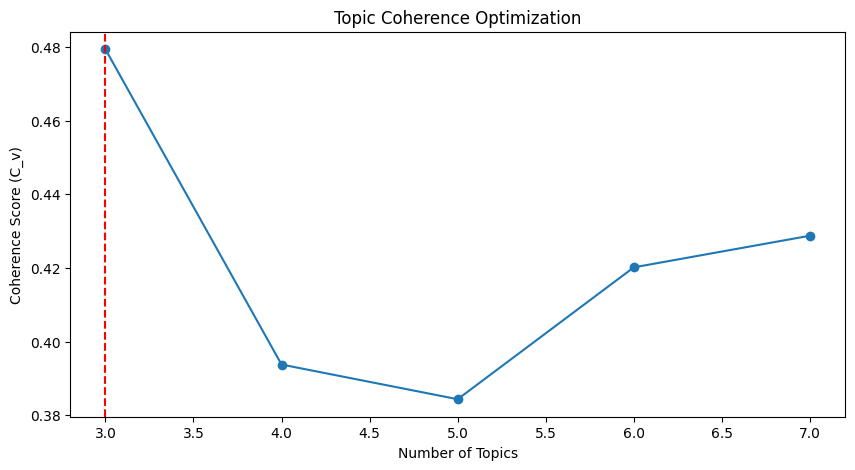


Optimal topics: 3
Best coherence: 0.4794


In [5]:
print("\nOptimizing topic count...")
coherence_scores = []
topic_numbers = range(3, 8)
best_model = None

for num_topics in topic_numbers:
    model = LdaModel(
        corpus=bow_corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=30,
        alpha='auto',
        random_state=42
    )
    
    coherence = CoherenceModel(
        model=model,
        texts=processed_data,
        dictionary=dictionary,
        coherence='c_v'
    ).get_coherence()
    
    coherence_scores.append(coherence)
    if not best_model or coherence > max(coherence_scores[:-1]):
        best_model = model
    print(f"Topics: {num_topics} | Coherence: {coherence:.4f}")

# Final model setup
best_idx = np.argmax(coherence_scores)
num_topics = topic_numbers[best_idx]
ldamodel = best_model

# Show coherence plot
plt.figure(figsize=(10,5))
plt.plot(topic_numbers, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (C_v)")
plt.title("Topic Coherence Optimization")
plt.axvline(x=num_topics, color='r', linestyle='--')
plt.show()

# Display results
print(f"\nOptimal topics: {num_topics}")
print(f"Best coherence: {max(coherence_scores):.4f}")

In [6]:
print("\nTopic keywords:")
topics = ldamodel.show_topics(num_topics=num_topics, num_words=10, formatted=False)
for topic_id, topic_terms in topics:
    words = [word for word, _ in topic_terms]
    print(f"Topic {topic_id}: {', '.join(words)}")


Topic keywords:
Topic 0: book, story, read, one, sandman, neil_gaiman, reading, first, wrote, comic
Topic 1: good_omen, show, view_neil, gaiman_whosay, photo, season, see, doctor, amanda, crowley
Topic 2: people, like, know, thing, would, think, get, one, time, make



Generating word clouds...


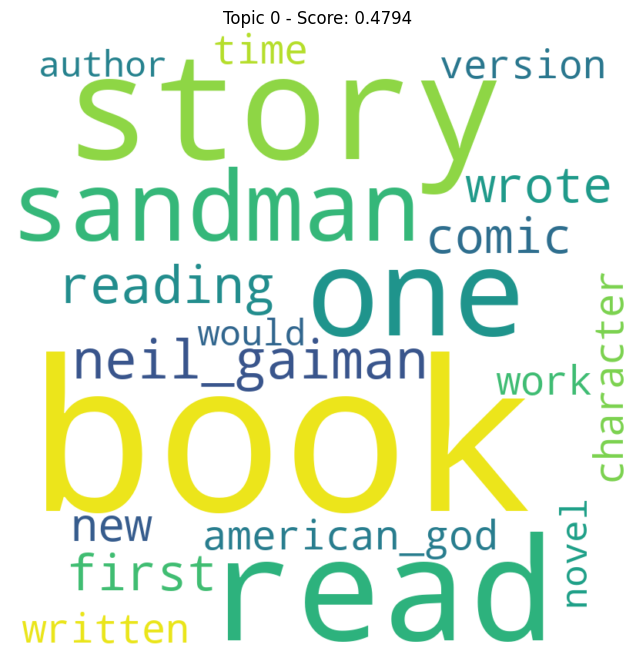

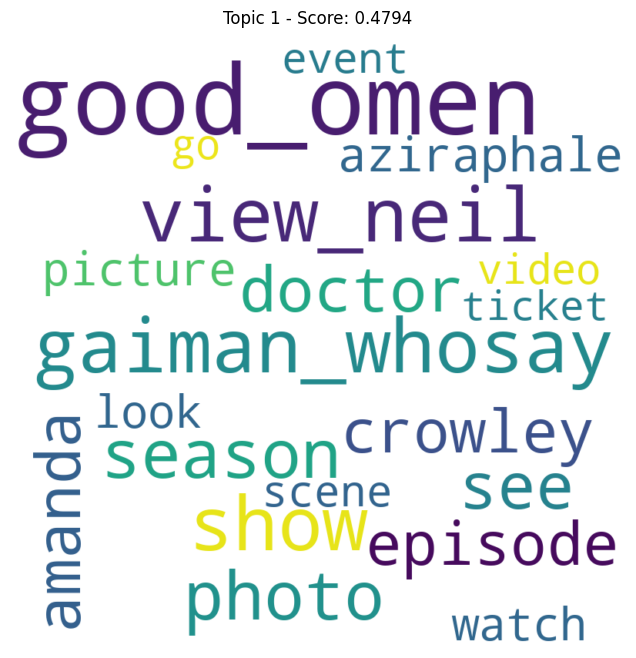

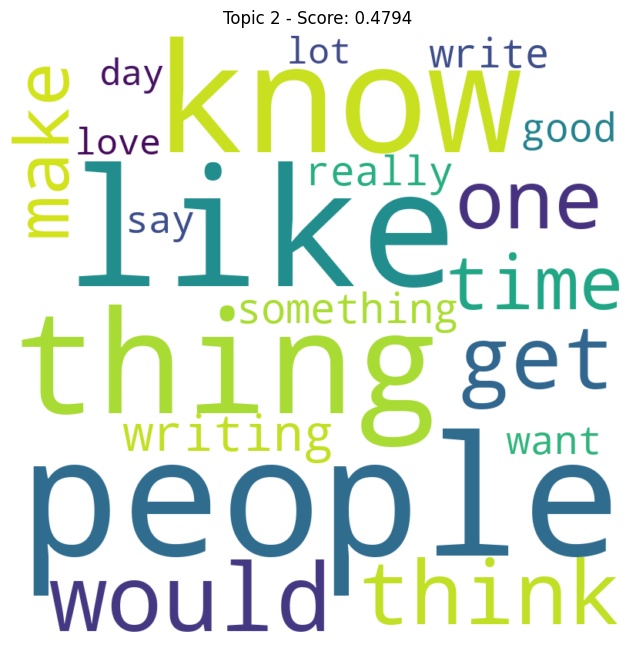

In [7]:
print("\nGenerating word clouds...")
for topic_id in range(num_topics):
    topic_terms = ldamodel.show_topic(topic_id, topn=20)
    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(dict(topic_terms))  # Use frequencies
    
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topic {topic_id} - Score: {coherence_scores[best_idx]:.4f}")
    plt.axis("off")
    plt.show()


Analyzing co-occurrence network...


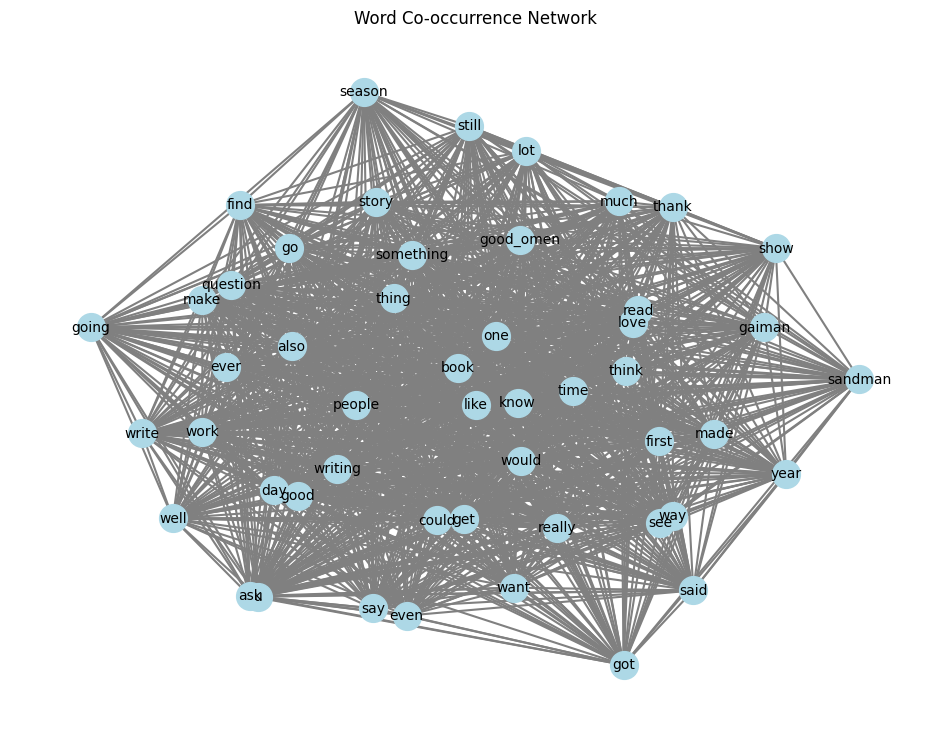


Process completed successfully!


In [8]:
# Network analysis
print("\nAnalyzing co-occurrence network...")
all_tokens = [token for doc in df['Processed'] for token in doc]
top_tokens = set([token for token, _ in nltk.FreqDist(all_tokens).most_common(50)])

cooccurrence_counts = Counter()
for doc in df['Processed']:
    filtered = list(set([t for t in doc if t in top_tokens]))
    for combo in itertools.combinations(sorted(filtered), 2):
        cooccurrence_counts[combo] += 1

G = nx.Graph()
for (w1, w2), count in cooccurrence_counts.items():
    if count >= 5:
        G.add_edge(w1, w2, weight=count)

if G.edges():
    plt.figure(figsize=(12,9))
    pos = nx.spring_layout(G, k=0.3)
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, width=1.5, edge_color='grey')
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title("Word Co-occurrence Network")
    plt.axis("off")
    plt.show()
else:
    print("No significant co-occurrences found")

print("\nProcess completed successfully!")